# Course Title: Data Analytics & Statistics in Python
## Metropolia University of Applied Sciences
## Week 4: Probability and Variability
### Date: 26.3.2025

<table "<table style="width: 100%;">
  <tr>
    <td style="text-align: left; vertical-align: middle;">
      <ul style="list-style: none; padding-left: 0;">
        <li><strong>Instructor</strong>: Hamed Ahmadinia, Ph.D</li>
        <li><strong>Email</strong>: hamed.ahmadinia@metropolia.fi
        <li><strong>Web</strong>: www.ahmadinia.fi</li>          </li>
      </ul>
    </td>
  </tr>
</table>

**© 2025 Hamed Ahmadinia – [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)**

In [1]:
# Import necessary libraries for our data analysis and statistical tests:
import pandas as pd  # For reading CSV files and handling tabular data in DataFrames
import numpy as np   # For numerical computations and array-based operations
import matplotlib.pyplot as plt  # For creating visual plots, e.g., histograms, line charts
from scipy.stats import (
    ttest_1samp,     # One-sample T-test (compare sample mean to a hypothesized value)
    ttest_ind,       # Two-sample T-test (compare means of two independent samples)
    mannwhitneyu,    # Mann-Whitney U (non-parametric test for two independent groups)
    shapiro,         # Shapiro-Wilk test (checks if data is normally distributed)
    chisquare,       # Chi-square test (commonly for goodness-of-fit on categorical data)
    chi2_contingency # Chi-square test for independence (analyzes contingency tables)
)

## **1. Loading the Dataset**
In this step, we load the **EPA Sea Level** dataset from the provided GitHub URL.
This dataset contains historical sea-level measurements over time, including
“CSIRO Adjusted Sea Level,” error bounds, and “NOAA Adjusted Sea Level” (with
 non-null entries).

**Why we do it**: We need real-world data to demonstrate the statistical
concepts like distributions, outlier detection, and hypothesis testing.

**Key action**: Use pandas `read_csv` to load the file and preview the first few
rows to confirm correct loading.ure.


In [2]:
# Load dataset from GitHub URL
file_path = "https://raw.githubusercontent.com/Hamed-Ahmadinia/DASP-2025/refs/heads/main/epa-sea-level.csv"  # URL link to the dataset stored on GitHub

# Read the dataset into a pandas dataframe
df = pd.read_csv(file_path)  # Load the dataset as a pandas DataFrame

# Display the first few rows of the dataframe to confirm the data has been loaded correctly
print("Dataset Preview:")
print(df.head(5))

Dataset Preview:
   Year  CSIRO Adjusted Sea Level  Lower Error Bound  Upper Error Bound  \
0  1880                  0.000000          -0.952756           0.952756   
1  1881                  0.220472          -0.732283           1.173228   
2  1882                 -0.440945          -1.346457           0.464567   
3  1883                 -0.232283          -1.129921           0.665354   
4  1884                  0.590551          -0.283465           1.464567   

   NOAA Adjusted Sea Level  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  


## **2. Basic Exploratory Dataset**

We check:

1. **Shape** of the DataFrame (rows × columns).
2. **Data types** (are columns numeric or string?).
3. **Descriptive statistics** (mean, min, max, quartiles).

**Why**: A quick overview helps us see missing data, detect possible data problems, and understand ranges of each column before deeper analysis.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*03D9umtAeoGnFXYH-Ycm8A.png" alt="Data Science Process" width="600"/>

> 📌 **Comment**: The steps we perform here are part of the broader **Data Science Process**. As shown in the figure above, this early-stage **exploratory data analysis (EDA)** — including shape, types, and summary statistics — feeds directly into data cleaning and modeling. These steps help us better understand the data before applying any algorithms or making decisions..


In [3]:
# Display shape, column info, and basic summary
print("DataFrame Shape:", df.shape)
print("\nColumn Info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())

DataFrame Shape: (134, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      134 non-null    int64  
 1   CSIRO Adjusted Sea Level  134 non-null    float64
 2   Lower Error Bound         134 non-null    float64
 3   Upper Error Bound         134 non-null    float64
 4   NOAA Adjusted Sea Level   21 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 5.4 KB
None

Descriptive Statistics:
              Year  CSIRO Adjusted Sea Level  Lower Error Bound  \
count   134.000000                134.000000         134.000000   
mean   1946.500000                  3.650341           3.204666   
std      38.826537                  2.485692           2.663781   
min    1880.000000                 -0.440945          -1.346457   
25%    1913.250000                  1.632874           1

## **3. Check Data Distribution Using Shapiro-Wilk Test**

We apply the **Shapiro-Wilk test** to each numeric column (or a random subset if the column is large). This test checks whether data likely comes from a **normal** distribution:

- If `p > 0.05`, we usually say the data “does not deviate significantly from normal” (i.e., could be normal).
- If `p <= 0.05`, we say it may not be normal.

**Why**: Many statistical tests (like t-tests) assume normal data. This helps us decide if we can use parametric tests or need non-parametric alternatives.

<img src="https://blogger.googleusercontent.com/img/a/AVvXsEhx17znSE17sn4oPqq3bXvxw7_Df0zGsN9imB7AK6_IDA5nrBq-A1aIG5q03zK_CNLlGRawxBQIWUKPQU4vh3U34YcONBFU75kqfbphhG_WVTcy52vkutvsf5AO8X_f-KCd_6C1uH27PDXMFbXiKWWb2h_mROTgR5KPsiHhOGxG3rd8vrRyWFdyEdMp=w547-h360" alt="Distribution Types" width="600"/>

> 📊 **Comment**: The chart above illustrates common distribution types—such as **normal**, **log-normal**, **binomial**, and skewed distributions. The Shapiro-Wilk test helps identify whether our dataset resembles a normal distribution or one of these alternatives, which influences the type of statistical tests we hould use.


In [4]:
# Check Data Distribution Using Shapiro-Wilk Test

def check_distribution(df):
    distribution_results = {}
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        col_data = df[col].dropna()
        if len(col_data) > 2:  # Shapiro requires at least 3 data points
            sample_size = min(len(col_data), 5000)
            sample = col_data.sample(n=sample_size, random_state=42)
            stat, p = shapiro(sample)
            distribution_results[col] = "Normal" if p > 0.05 else "Not Normal"
        else:
            distribution_results[col] = "Test Failed (too few data)"

    return distribution_results

distribution_results = check_distribution(df)
print("Distribution Check:\n", distribution_results)

Distribution Check:
 {'Year': 'Not Normal', 'CSIRO Adjusted Sea Level': 'Not Normal', 'Lower Error Bound': 'Not Normal', 'Upper Error Bound': 'Not Normal', 'NOAA Adjusted Sea Level': 'Normal'}


## **4. Recommend Missing Data Imputation Strategy**

We examine how many values are missing in each column. Then, based on the percentage of missing data (like <5%, <20%, etc.), we propose imputation strategies:

- **Mode Imputation**: For categorical columns (e.g., Gender, Country) with low missingness.
- **Median Imputation**: If few numeric values are missing and the data isn't too large.
- **KNN Imputation**: For numeric columns with moderate missingness; uses similar rows for better estimates.
- **Multiple Imputation (MICE)**: When multiple variables have missing data and relationships among them matter.
- **Model-Based Imputation**: For advanced cases where statistical or machine learning models can predict missing values.
- **Removal**: If too many values are missing (e.g., >40%), we may drop the column or rows.

**Why**: Handling missing data carefully is crucial for correct analysis. Different missingness types (MCAR, MAR, MNAR) and variable types require different strategies.

<img src="https://miro.medium.com/v2/resize:fit:1894/1*vhwpR-qisCWFdpmAugxcIA.jpeg" alt="Missing Data Treatment Strategies" width="600"/>

> 🧠 **Comment**: The visual above categorizes missing data into **MCAR**, **MAR**, and **MNAR** — each with different treatment approaches. Understanding the nature of missingness helps us choose the most suitable imputtion strategy.


In [5]:
# Recommend Missing Data Imputation Strategy

def recommend_imputation(df, distribution_results):
    recommendations = {}  # Dictionary to store imputation recommendations for each column

    for column in df.columns:
        missing_count = df[column].isnull().sum()
        total_count = len(df)
        missing_percentage = (missing_count / total_count) * 100
        dist = distribution_results.get(column, "Not Checked")
        col_dtype = df[column].dtype

        print(f"\nColumn: {column}")
        print(f"Missing: {missing_count} ({missing_percentage:.2f}%)")
        print(f"Data Type: {col_dtype}")
        print(f"Distribution: {dist}")

        if missing_count == 0:
            print("Recommendation: No missing values")
            recommendations[column] = "No missing values"
            continue

        if col_dtype == 'object' or str(col_dtype) == 'category':
            # Categorical column
            if missing_percentage < 40:
                print("Recommendation: Use Mode Imputation (Categorical)")
                recommendations[column] = "Use Mode Imputation"
            else:
                print("Recommendation: Too many missing values — consider removing")
                recommendations[column] = "Too many missing values — consider removing"
        else:
            # Numeric column
            if missing_percentage < 5:
                print("Recommendation: Use Median Imputation")
                recommendations[column] = "Use Median Imputation"
            elif missing_percentage < 20:
                print("Recommendation: Use KNN Imputation or Median Imputation")
                recommendations[column] = "Use KNN Imputation or Median Imputation"
            elif missing_percentage < 30:
                print("Recommendation: Consider Multiple Imputation (MICE)")
                recommendations[column] = "Consider Multiple Imputation (MICE)"
            elif missing_percentage < 40:
                print("Recommendation: Use Model-Based Imputation")
                recommendations[column] = "Use Model-Based Imputation"
            else:
                print("Recommendation: Too many missing values — consider removing")
                recommendations[column] = "Too many missing values — consider removing"

    return recommendations

# Apply the function
missing_recommendations = recommend_imputation(df, distribution_results)


Column: Year
Missing: 0 (0.00%)
Data Type: int64
Distribution: Not Normal
Recommendation: No missing values

Column: CSIRO Adjusted Sea Level
Missing: 0 (0.00%)
Data Type: float64
Distribution: Not Normal
Recommendation: No missing values

Column: Lower Error Bound
Missing: 0 (0.00%)
Data Type: float64
Distribution: Not Normal
Recommendation: No missing values

Column: Upper Error Bound
Missing: 0 (0.00%)
Data Type: float64
Distribution: Not Normal
Recommendation: No missing values

Column: NOAA Adjusted Sea Level
Missing: 113 (84.33%)
Data Type: float64
Distribution: Normal
Recommendation: Too many missing values — consider removing


## **5. Probability Distribution & Descriptive Stats**

We focus on one numeric column (e.g., `'CSIRO Adjusted Sea Level'`) to explore fundamental descriptive statistics and distribution shapes:

1. **Mean (Expected Value)**: Represents the average value — the central tendency.
2. **Variance**: Measures how far the data points are spread out from the mean. It’s expressed in **squared units**.
3. **Standard Deviation**: The square root of variance — easier to interpret because it uses the **same units** as the original data.

We then plot a **histogram** to visualize the distribution of values. Is it:
- **Bell-shaped**? → Suggests a normal distribution.
- **Skewed**? → Suggests log-normal, exponential, or other asymmetry.
- **Multimodal**? → Might indicate subgroups or mixed populations.

---

### 🎯 Expected Value (Mean)

In probability theory, the **expected value** \(E[X]\) is the long-term average of a random variable. For discrete distributions:

$$
E[X] = \sum_{i=1}^n p(x_i) \cdot x_i
$$

If all probabilities are equal, it’s equivalent to the arithmetic mean.

The **Law of Large Numbers** tells us that as we collect more samples, the sample mean converges to the true expected value — a foundational principle for statistical reliability.

---

### 📈 Variance and Standard Deviation

These measure **how spread out** the data is:

- **Variance** is the average of the squared differences from the mean.
- **Standard deviation** is the square root of variance, and is easier to interpret because it’s in the same units as the data.

---

### 👨‍🏫 Example

Let's say three students got the following scores on a quiz:

- **Scores**: 70, 80, 90

### Step 1: Mean  
$$
\text{Mean} = \frac{70 + 80 + 90}{3} = 80
$$

### Step 2: Variance  
$$
\text{Variance} = \frac{(70 - 80)^2 + (80 - 80)^2 + (90 - 80)^2}{3} = \frac{100 + 0 + 100}{3} = 66.67
$$

### Step 3: Standard Deviation  
$$
\text{SD} = \sqrt{66.67} \approx 8.16
$$

So the **average score** is 80. The **variance** tells us that, on average, the squared difference from the mean is about 66.67. The **standard deviation** of approximately 8.16 means that most scores are about 8 points away from the mean — a useful way to understand the spread in the same units as the original data.

---

### 📐 Visual Summary: Standard Deviation vs. Variance

<img src="https://www.6sigma.us/wp-content/uploads/2024/09/standard-deviation-vs-variance.webp" alt="Standard Deviation vs Variance" width="500"/>

> 📌 **Interpretation**:  
> - **Standard Deviation** is easier to interpret and in the same units as the data (e.g., test scores).  
> - **Variance** is mathematically useful (e.g., in machine learning) but harder to grasp directly because it uses squared units.

---

### 📊 Distribution Shapes

To complement the stats above, we use **histograms** to examine shape:

- **Normal**: Symmetric bell curve  
- **Skewed**: Long tail on one side (e.g., income)  
- **Uniform**: All values equally likely  
- **Bimodal**: Two peaks (e.g., subgroups in data)  

Plotting histograms helps reveal whether the data meets assumptions for various statistical tests.

Mean (Expected Value): 3.6503
Variance: 6.1787
Standard Deviation: 2.4857


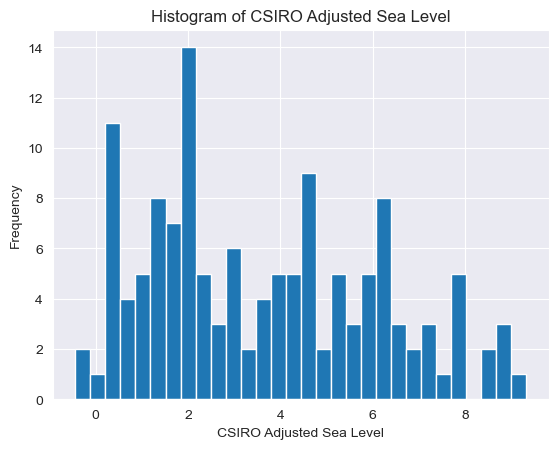

In [6]:
# Replace 'CSIRO Adjusted Sea Level' with the correct numeric column name in df
column_name = 'CSIRO Adjusted Sea Level'  # <-- Update to match actual column name if different

# Drop NaN values just in case
sea_levels = df[column_name].dropna()

# Mean, Variance, and Standard Deviation
mean_val = np.mean(sea_levels)
var_val = np.var(sea_levels, ddof=1)     # sample variance
std_val = np.std(sea_levels, ddof=1)     # sample standard deviation

print(f"Mean (Expected Value): {mean_val:.4f}")
print(f"Variance: {var_val:.4f}")
print(f"Standard Deviation: {std_val:.4f}")

# Visualize distribution
plt.hist(sea_levels, bins=30) 
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel("Frequency")
plt.show()

The histogram shows the distribution of the **CSIRO Adjusted Sea Level** values in our dataset.

We also calculated key descriptive statistics:

- The **mean** value of approximately **3.65** indicates the average sea level rise in the dataset.
- The **variance** of **6.18** tells us how spread out the values are — specifically, it’s the average of the squared differences from the mean.
- The **standard deviation** of **2.49** shows that most of the sea level values are within **±2.49 units** of the mean — a more interpretable measure than variance since it shares the same units as the data.
- The histogram is **asymmetric** and **slightly skewed**, suggesting that the distribution **is not perfectly normal**.
- There's a **wide spread** in the values, ranging from slightly below 0 to above 9.
- The data is **multimodal** — with multiple peaks — which might indicate that different phases or patterns of sea level change are captured across the years.

## **6. Z-score & Outlier Detection**

Outliers are data points that differ significantly from others in the dataset. They may result from data entry errors, rare events, or natural variation in the data.

---

### 🧠 What is a Z-score?

A **Z-score** (or standardized score) tells us **how many standard deviations a value is from the mean**:

$$
z = \frac{x - \mu}{\sigma}
$$

Where:  
- \(x\) = data point  
- \(\mu\) = mean of the dataset  
- \(\sigma\) = standard deviation

Z-scores **standardize data**, allowing us to identify unusually high or low values consistently across variables.

---

### 📉 Z-score Thresholds

- If \(|z| > 3\), the value is typically considered an **outlier**.
- Sometimes a threshold of **2.5** or **4** is used, depending on the dataset size and context.

This method is most effective when data is **approximately normally distributed**.

---

### 📦 Outliers in Boxplots

Another visual way to detect outliers is using **boxplots**, which highlight extreme values based on quartiles and the **interquartile range (IQR)**:

- **Q1 (25th percentile)**
- **Q3 (75th percentile)**
- **IQR = Q3 - Q1**
- Outliers = values below Q1 − 1.5×IQR or above Q3 + 1.5×IQR

<img src="https://miro.medium.com/v2/resize:fit:936/1*7IUamziszaFcMKk26FpRZA.jpeg" alt="Boxplot explanation" width="500"/>

---

### ❓ Why Detect Outliers?

- ✅ Helps clean noisy or erroneous data  
- ✅ Improves accuracy of statistical analyses and models  
- ✅ Prevents misleading averages and variance  
- ⚠️ **Note**: Not all outliers are errors — some represent **meaningful rare elp ensure cleaner, more trustworthy data for analysis.
-

In [7]:
def detect_outliers_zscore(df, threshold=3):
    outliers_dict = {}
    
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        col_data = df[col].dropna()
        mean_val = col_data.mean()
        std_val = col_data.std(ddof=0)  # population std, or ddof=1 for sample

        # Avoid division by zero if std_val is 0
        if std_val == 0:
            outliers_dict[col] = 0
            continue
        
        z_scores = (col_data - mean_val) / std_val
        outliers_mask = abs(z_scores) > threshold
        num_outliers = outliers_mask.sum()
        outliers_dict[col] = num_outliers

    return outliers_dict

# Example usage:
outliers_per_column = detect_outliers_zscore(df, threshold=3)
print("Outliers per column:\n", outliers_per_column)

Outliers per column:
 {'Year': 0, 'CSIRO Adjusted Sea Level': 0, 'Lower Error Bound': 0, 'Upper Error Bound': 0, 'NOAA Adjusted Sea Level': 0}


## **7. One-Sample T-test**

### ❓ What Does a One-Sample T-test Do?

A **one-sample t-test** checks whether the **mean of a sample** significantly differs from a known or hypothesized **population mean**.

- **Null Hypothesis (H₀)**: The true mean = hypothesized value (e.g., 5)
- **Alternative Hypothesis (H₁)**: The true mean ≠ hypothesized value

We perform this test when we want to compare our sample (e.g., user test scores, heart rate, etc.) to a **benchmark** or known value.

---

### 🧠 Statistical Assumptions (for all t-tests)

To ensure valid results, the t-test relies on the following assumptions:

1. The data are **continuous**
2. The sample is **random and independent**
3. The variance in the population is **constant (homogeneity of variance)**
4. The data are **approximately normally distributed**

💡 The **t-distribution** has heavier tails than the normal distribution to account for smaller samples. As the sample size increases, the t-distribution approaches the normal distribution.

---

### 🔍 Visual Guide: Types of T-tests

<img src="https://thedatascientist.com/wp-content/uploads/2023/08/paired-t-test.png" alt="Types of T-tests" width="600"/>

| T-test Type            | Description                                                        | Typical Use-Case |
|------------------------|--------------------------------------------------------------------|------------------|
| **One-Sample**         | Compares sample mean to a population or theoretical mean           | Is the average blood pressure in our sample different from the national average? |
| **Two-Sample (Independent)** | Compares means of two different, unrelated groups               | Do smokers and non-smokers have different lifespans? |
| **Paired-Sample**      | Compares means of the same group at two different times or conditions | Did a training program imnT-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


In [8]:
# Column to test
column_name = 'CSIRO Adjusted Sea Level'
sea_levels = df[column_name]

# Calculate the sample mean
sample_mean = sea_levels.mean()
print(f"Sample Mean: {sample_mean:.4f}")

# Define hypothesized population mean (e.g., historical benchmark or policy threshold)
hypothesized_mean = 3.0

# Perform one-sample t-test
t_stat, p_val = ttest_1samp(sea_levels, popmean=hypothesized_mean)

# Output results
print("\nOne-sample T-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.6f}")

# Interpretation guide
if p_val < 0.05:
    print("✅ Result: Reject the null hypothesis — the mean is significantly different.")
else:
    print("ℹ️ Result: Fail to reject the null — no significant difference from the hypothesized mean.")

Sample Mean: 3.6503

One-sample T-test Results:
T-statistic: 3.0286
P-value: 0.002952
✅ Result: Reject the null hypothesis — the mean is significantly different.


## **8. Two-Sample T-test (Older Years vs. Recent Years)**

The **two-sample t-test** (also called **independent t-test**) compares the means of **two independent groups** to assess if they are statistically different.

- **Group A**: Sea level values before 1950  
- **Group B**: Sea level values from 1950 onward

---

### 🧪 Hypotheses

- **Null Hypothesis (H₀)**: The two groups have equal means  
  \[
  H_0: \mu_1 = \mu_2
  \]
- **Alternative Hypothesis (H₁)**: The means are different  
  \[
  H_1: \mu_1 \neq \mu_2
  \]

If the **p-value < 0.05**, we reject the null hypothesis and conclude that the difference in means is **statistically significant**.

---

### 🧠 Use This When:

- You want to compare **two independent samples**
- Example: Sea level measurements before and after a certain year, or from two different regions

---

### 📌 Summary

- Use a **one-sample t-test** when comparing your data to a **fixed reference or known mean**
- Use a **two-sample t-test** when comparing the **means of two separate, unrelated groups**
- Always check assumptions like normality and equal variances, especially for smaller sample sizes

These statistical tests help us **quantify evidence** about group differences and make data-driven decisions with confidence.

In [9]:
# Define column names
year_column = 'Year'
column_name = 'CSIRO Adjusted Sea Level'

# Split the data into two groups based on the year
groupA = df[df[year_column] < 1950][column_name]
groupB = df[df[year_column] >= 1950][column_name]

# Perform two-sample t-test (Welch’s test is used here by setting equal_var=False)
t_stat_2, p_val_2 = ttest_ind(groupA, groupB, equal_var=False)

# Output results
print("Two-sample T-test (older vs. recent years):")
print(f"T-statistic: {t_stat_2:.4f}")
print(f"P-value: {p_val_2:.6f}")
print("Group A size:", len(groupA), "Group B size:", len(groupB))

Two-sample T-test (older vs. recent years):
T-statistic: -19.3116
P-value: 0.000000
Group A size: 70 Group B size: 64


Since the **p-value is far below 0.05**, we **reject the null hypothesis**.

This provides **strong statistical evidence** that the average CSIRO adjusted sea level in the **recent years** (1950 onward) is significantly **different** from the average in the **older years** (before 1950).

The **negative t-statistic** indicates that the mean in **Group A (older years)** is **lower** than in **Group B (recent years)**, supporting the idea of **rising sea levels over time**.

## **9. Statistical Tests: Mann-Whitney U Test**

The **Mann-Whitney U Test** is a **non-parametric alternative** to the two-sample t-test.  
Rather than comparing **means**, it evaluates whether **one group tends to have higher or lower values** by comparing **rank sums** — making it ideal when your data **is not normally distributed** or is **ordinal** (like Likert scale responses).

---

### 🧪 When to Use It

- Data is **not normally distributed**
- Variables are **ordinal** (e.g., survey responses, Likert scales)
- Comparing **two independent groups**
- You need a test that’s **robust to outliers**

---

### ⚖️ How It Works

- All values are **ranked** together across both groups
- The **sum of ranks** for each group is calculated
- If one group consistently has **higher or lower ranks**, the distributions are likely different
- A **small p-value (< 0.05)** suggests a **statistically significant difference** between the groups

---

### 📊 Visual Comparison

<img src="https://datatab.net/assets/tutorial/uTest/Mann-Whitney_U_Test_VS_t-Test.png" alt="Mann-Whitney U vs t-test" width="600"/>

> - **T-test**: Detects difference in **means**  
> - **Mann-Whitney U**: Detects difference in **rank distributions**  
>   (i.e., which group tends to score higher overall)

---

### 💡 Interpretation Example

Let’s say you conduct a Mann-Whitney U test comparing survey ratings U-statistic: 4.000, P-value: 0.027 
Since **p < 0.05**, you **reject the null hypothesis**.  
This suggests that one group **tends to give higher or lower scores** than the other — indicating a meaningful difference in response patterns.

---

### ✅ Summary

| Criteria               | **t-Test**                  | **Mann-Whitney U Test**       |
|------------------------|-----------------------------|-------------------------------|
| Data Type              | Continuous (Normal)         | Ordinal / Non-Normal          |
| What It Compares       | Means                       | Rank Distributions            |
| Assumes Normality?     | ✅ Yes                      | ❌ No                          |
| Robust to Outliers     | ❌ No                       | ✅ Yes                         |
| Typical Use Case       | Heights, weights, income    | Likert scales, satisfaction   |

---

> 📌 **Conclusion**:  
The Mann-Whitney U Test is a powerful and flexible tool when you're analyzing **non-normal** or **rank-based** data.  
It’s especially useful in social science, health, and behavioral studies where assumptions of normaliy often don’t hold.
rom two independent groups and get:



In [10]:
u_stat, p_val_u = mannwhitneyu(groupA, groupB, alternative='two-sided')
print("Mann-Whitney U Test:")
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_val_u:.6f}")

Mann-Whitney U Test:
U-statistic: 0.0000
P-value: 0.000000


Since the **p-value is far below 0.05**, we **reject the null hypothesis**.

This provides **very strong evidence** that the distribution of CSIRO adjusted sea levels is **significantly different** between years **before 1950** and **from 1950 onward**.

A **U-statistic of 0** means that **every value in Group B (recent years)** is **greater than every value in Group A (older years)** — a strong signal that sea levels have **consistently increased** over time.

This result supports the idea of a long-term upward trend in sea levels.

## **10. Chi-Squared Tests (χ²)**

The **Chi-Squared Test** is a **non-parametric** test used to examine relationships or distributions involving **categorical variables**. It helps answer two key questions:

---

### 🧪 Types of Chi-Squared Tests

| Test Type                      | Purpose                                                              | Use Case Example                                                  |
|-------------------------------|----------------------------------------------------------------------|------------------------------------------------------------------|
| **Chi-Squared Test for Independence** | Tests if two categorical variables are associated                     | Is education level related to voting preference?                |
| **Chi-Squared Goodness of Fit Test** | Tests if observed frequencies fit an expected distribution             | Is a die fair (i.e., all sides equally likely)?                 |

---

### 📊 When to Use Chi-Squared Tests

- Your data consists of **frequencies or counts**, not means
- The variables are **categorical** (e.g., Gender, Preference, Age Group)
- Observations are **independent**
- **Expected frequency** in each cell should be **≥ 5**

---

### 📐 How It Works

- **Goodness of Fit**: Compares observed counts to expected counts (e.g., uniform or known proportions)
- **Test for Independence**: Uses a **contingency table** to check whether two categorical variables are **associated or independent**

---

### 📋 Hypotheses

#### Goodness of Fit
- **H₀**: Observed frequencies match expected frequencies  
- **H₁**: Observed frequencies do not match expected frequencies

#### Test for Independence
- **H₀**: The two variables are independent (no relationship)  
- **H₁**: The variables are associated (dependent)

---

### 📊 Visual Example

<img src="https://datatab.net/assets/tutorial/chi/Chi-Square-test.png" alt="Chi-Square test example" width="600"/>

In this case, we’re testing if there’s a **relationship between gender and education level**.

---

### 💡 Interpretation
 Goodness of Fit: Chi² = 6.500, p = 0.039

Test of Independence: Chi² = 30.000, p = 0.000, DoF = 4E
- In both cases, the **p-values are < 0.05**, so we **reject the null hypothesis**
- This suggests:
  - The observed distribution **does not match** the expected
  - The two variables **are not independent** (i.e., there is a relationship)

---

### ✅ Summary

| Feature                    | Goodness of Fit                        | Test of Independence                       |
|---------------------------|----------------------------------------|--------------------------------------------|
| Goal                      | Match observed to expected distribution| Check relationship between two variables    |
| Data Structure            | Single categorical variable            | Contingency table (2 categorical variables) |
| Example                   | Dice fairness test                     | Gender vs. Education level                 |
| Null Hypothesis (H₀)      | Observed = Expected                    | Variables are independent                   |
| Assumptions               | Expected frequency ≥ 5, Independence   | Same as left                               |

---

> 📌 **Conclusion**:  
Chi-squared tests are powerful tools for analyzing **categorical data**, whether you're testing **fairness, distribution fit**, or **associations between variables** — no need for normality assumptions.
xample

Suppose we perform both tests and obtain:



In [11]:
# 1. Extract the column
sea_levels = df['CSIRO Adjusted Sea Level']  # already confirmed: no missing values

# 2. Define bin thresholds based on 33rd and 66th percentiles
p33, p66 = np.percentile(sea_levels, [33, 66])

# 3. Categorize sea levels into 3 bins
def categorize_sea_level(x):
    if x < p33:
        return "Low"
    elif x < p66:
        return "Medium"
    else:
        return "High"

categories = [categorize_sea_level(x) for x in sea_levels]

# 4. Observed frequencies
unique_cats, counts = np.unique(categories, return_counts=True)
print("Observed categories:", unique_cats)
print("Observed counts:", counts)

# 5. Expected frequencies: assume uniform distribution
total = sum(counts)
expected = [total / len(unique_cats)] * len(unique_cats)
print("Expected (uniform) counts:", expected)

# 6. Perform Chi-squared Goodness of Fit test
chi2_stat, p_val_chi = chisquare(f_obs=counts, f_exp=expected)

print("\nChi-squared Goodness of Fit Test:")
print(f"Chi2 Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_val_chi:.6f}")

Observed categories: ['High' 'Low' 'Medium']
Observed counts: [46 44 44]
Expected (uniform) counts: [44.666666666666664, 44.666666666666664, 44.666666666666664]

Chi-squared Goodness of Fit Test:
Chi2 Statistic: 0.0597
P-value: 0.970590


We categorized CSIRO adjusted sea levels into three groups — **Low**, **Medium**, and **High** — using the 33rd and 66th percentiles as cutoffs.

- **Observed Counts**:  
  - High: 46  
  - Medium: 44  
  - Low: 44  
- **Expected Counts (Uniform Distribution)**: ~44.67 per category
- **Chi² Statistic**: 0.0597  
- **P-value**: 0.970590

- The **p-value is much greater than 0.05**, so we **fail to reject the null hypothesis**.
- This means there is **no significant difference** between the observed and expected frequencies.
- In other words, the distribution of sea level values across the **Low**, **Medium**, and **High** categories is **approximately uniform**.

This suggests that, based on the percentile binning, sea levels are **fairly evenly distributed** across the range — no category is disproportionately represented.

In [12]:
# Define column explicitly
column_name = 'CSIRO Adjusted Sea Level'
sea_levels = df[column_name]

# 1. Create SeaLevelCat (Above or Below Mean)
mean_sea_level = sea_levels.mean()

def sea_level_category(x):
    return "BelowMean" if x < mean_sea_level else "AboveMean"

df['SeaLevelCat'] = df[column_name].apply(sea_level_category)

# 2. Create YearCat (Time period bins)
def categorize_year(y):
    if y < 1950:
        return "Before1950"
    elif y < 2000:
        return "1950to2000"
    else:
        return "After2000"

df['YearCat'] = df['Year'].apply(categorize_year)

# 3. Drop any rows with missing values (precautionary)
df_subset = df.dropna(subset=['SeaLevelCat', 'YearCat'])

# 4. Create contingency table
contingency_table = pd.crosstab(df_subset['SeaLevelCat'], df_subset['YearCat'])
print("Contingency Table:\n", contingency_table)

# 5. Run Chi-squared Test of Independence
chi2_stat, p_val, dof, expected_freq = chi2_contingency(contingency_table)

print("\nChi-squared Test for Independence:")
print(f"Chi2 Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_val:.6f}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:\n", expected_freq)

Contingency Table:
 YearCat      1950to2000  After2000  Before1950
SeaLevelCat                                   
AboveMean            49         14           0
BelowMean             1          0          70

Chi-squared Test for Independence:
Chi2 Statistic: 130.0660
P-value: 0.000000
Degrees of Freedom: 2
Expected Frequencies:
 [[23.50746269  6.58208955 32.91044776]
 [26.49253731  7.41791045 37.08955224]]


We analyzed whether the **categorical sea level** status (**AboveMean** or **BelowMean**) is statistically associated with the **time period** (**Before1950**, **1950to2000**, **After2000**).

#### Contingency Table (Observed Frequencies):

| SeaLevelCat | Before1950 | 1950to2000 | After2000 |
|-------------|-------------|-------------|------------|
| **AboveMean** | 0           | 49          | 14         |
| **BelowMean** | 70          | 1           | 0          |

#### Chi-squared Test Results:

- **Chi² Statistic**: 130.0660  
- **P-value**: 0.000000  
- **Degrees of Freedom**: 2  

#### Expected Frequencies (if independent):

| SeaLevelCat | Before1950 | 1950to2000 | After2000 |
|-------------|-------------|-------------|------------|
| **AboveMean** | 32.91       | 23.51       | 6.58       |
| **BelowMean** | 37.09       | 26.49       | 7.42       |

---

Since the **p-value is far below 0.05**, we **reject the null hypothesis**.  
This means there's **strong statistical evidence** that **sea level category is not independent of the year**.

  **What this suggests**:
- In **earlier years (Before1950)**, nearly all sea levels were **BelowMean**
- In **recent years (1950 onward)**, sea levels have **shifted significantly upward**, with the vast majority falling in the **AboveMean** category

>   **Conclusion**:  
This supports the hypothesis that **sea levels have increased over time**, with a clear distributional shift occurring **after 1950** and intensifying **after 2000**.